### Long notebook
#### Group member:
- Ulrik Rørnes (527623)
- Sigurd Skatvedt ()
- Mads Olav Eek (529206)

#### Kaggle team name: 'kule gutter'

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

### First catboost model:


In [36]:
# Load a single set for initial exploration
train_targets = pd.read_parquet('A/train_targets.parquet')
X_train_observed = pd.read_parquet('A/X_train_observed.parquet')

# Check the first few rows to understand the time intervals
print(train_targets['time'].head())
print(X_train_observed['date_forecast'].head())



0   2019-06-02 22:00:00
1   2019-06-02 23:00:00
2   2019-06-03 00:00:00
3   2019-06-03 01:00:00
4   2019-06-03 02:00:00
Name: time, dtype: datetime64[ns]
0   2019-06-02 22:00:00
1   2019-06-02 22:15:00
2   2019-06-02 22:30:00
3   2019-06-02 22:45:00
4   2019-06-02 23:00:00
Name: date_forecast, dtype: datetime64[ns]


In [33]:
def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """
    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return merged_data, test_resampled

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


0:	learn: 594.7644197	total: 8.21ms	remaining: 8.2s
200:	learn: 192.8596165	total: 1.36s	remaining: 5.39s
400:	learn: 180.5368032	total: 2.47s	remaining: 3.69s
600:	learn: 174.3298784	total: 3.55s	remaining: 2.36s
800:	learn: 169.6346673	total: 4.67s	remaining: 1.16s
999:	learn: 164.5558480	total: 5.82s	remaining: 0us


/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


0:	learn: 92.3626894	total: 7.4ms	remaining: 7.39s
200:	learn: 35.2293994	total: 1.2s	remaining: 4.79s
400:	learn: 33.2446950	total: 2.55s	remaining: 3.82s
600:	learn: 32.1726808	total: 3.78s	remaining: 2.51s
800:	learn: 31.2183083	total: 4.96s	remaining: 1.23s
999:	learn: 30.4627761	total: 6.08s	remaining: 0us


/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3686481173.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()


0:	learn: 61.9661959	total: 8.42ms	remaining: 8.41s
200:	learn: 26.2793889	total: 1.3s	remaining: 5.18s
400:	learn: 24.2466777	total: 2.5s	remaining: 3.73s
600:	learn: 23.1525407	total: 3.77s	remaining: 2.5s
800:	learn: 22.3760541	total: 5.2s	remaining: 1.29s
999:	learn: 21.6791932	total: 6.65s	remaining: 0us


<Figure size 1000x400 with 0 Axes>

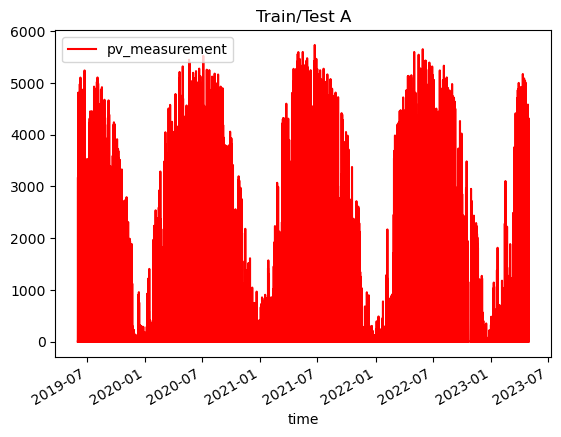

<Figure size 1000x400 with 0 Axes>

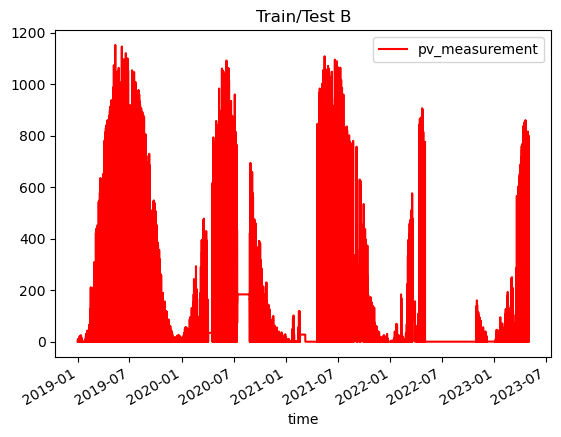

<Figure size 1000x400 with 0 Axes>

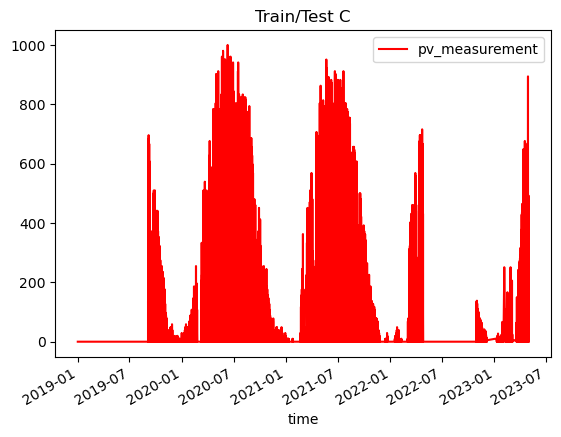

In [35]:
locations = ['A', 'B', 'C']
all_predictions = []

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Plotting target values to look for "noise"
    plt.figure(figsize=(10, 4)) 
    feature_name = 'pv_measurement'
    target_values = train
    target_values[['time', feature_name]].set_index('time').plot(title=f'Train/Test {loc}', color='red')

   # Preprocess data
    X_train, X_test = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = train['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]

    # Initialize and Train model
    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200)
    model.fit(X_train, y_train)

    # Make predictions using X_test_estimated data
    predictions = model.predict(X_test)
    
    # Store the predictions in all_predictions list
    all_predictions.append(predictions)

# Concatenate all predictions
final_predictions_cat1 = np.concatenate(all_predictions)

#### Second Catboost model with Randomforest

In [38]:
# List of locations
locations = ['A', 'B', 'C']

# Loop through each location
for loc in locations:
    # Load the data for the current location
    df = pd.read_parquet(f'{loc}/X_train_estimated.parquet')

    # Count NaN values for each feature
    nan_counts = df.isna().sum()

    # Filter counts greater than 5000
    large_nan_counts = nan_counts[nan_counts > 5000]

    # Print the results if any count is greater than 5000
    if not large_nan_counts.empty:
        print(f"Location {loc} - Features with more than 5000 NaNs:")
        print(large_nan_counts)

Location A - Features with more than 5000 NaNs:
snow_density:kgm3    15769
dtype: int64
Location B - Features with more than 5000 NaNs:
snow_density:kgm3    15713
dtype: int64
Location C - Features with more than 5000 NaNs:
snow_density:kgm3    13898
dtype: int64


In [39]:
def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

    # Removing consecutive duplicate non-zero values (removing "noise")
    targets = targets[(targets['pv_measurement'] == 0) | (targets['pv_measurement'] != targets['pv_measurement'].shift())]
    targets.dropna(inplace=True)

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Binary feature indicating whether the data is from an observed dataset or an estimated dataset.
    observed_resampled['estimated'] = 0
    estimated_resampled['estimated'] = 1
    test_resampled['estimated'] = 1
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 23)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 23)
    merged_data['day_of_week'] = merged_data['date_forecast'].dt.dayofweek
    merged_data['sin_day_of_week'] = np.sin(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['cos_day_of_week'] = np.cos(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['day_of_week'] = test_resampled['date_forecast'].dt.dayofweek
    test_resampled['sin_day_of_week'] = np.sin(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['cos_day_of_week'] = np.cos(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)
    
    # fixing NaN value
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
    merged_data['cloud_base_agl:m'].fillna(0, inplace=True)
    test_resampled['cloud_base_agl:m'].fillna(0, inplace=True)

    merged_data = merged_data.drop(columns=['time'])
    merged_data.to_csv(f'{loc}_csv/X_train.csv')
    test_resampled.to_csv(f'{loc}_csv/X_test.csv')

    # Drop non-feature columns
    # Drop 'snow_density:kgm3' as well, since it has a very large amount of NaN values.
    merged_data = merged_data.drop(columns=['date_forecast', 'pv_measurement', 'snow_density:kgm3'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'])
    
    return merged_data, test_resampled, targets

locations = ['A', 'B', 'C']
all_predictions = []
all_predictions_rf = []


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

   # Preprocess data
    X_train, X_test, targets = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = targets['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]
    
    X_train_data, X_eval_data, y_train_data, y_eval_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200, cat_features=['estimated'])
    model.fit(X_train, y_train, eval_set=(X_eval_data, y_eval_data))

    # Make predictions using X_test_estimated data
    predictions = model.predict(X_test)

    all_predictions.append(predictions)

    final_predictions = np.concatenate(all_predictions)
     
    # Initialize and Train RandomForest model
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)

    # Make predictions using X_test data
    predictions_rf = model_rf.predict(X_test)
    
    # Store the RandomForest predictions in all_predictions_rf list
    all_predictions_rf.append(predictions_rf) 
    
    final_predictions_rf = np.concatenate(all_predictions_rf)
    
average_predictions = (np.array(final_predictions) + np.array(final_predictions_rf)) / 2.0
final_predictions_cat2 = average_predictions
    

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 584.1834784	test: 558.4020079	best: 558.4020079 (0)	total: 15.1ms	remaining: 15.1s
200:	learn: 194.8668291	test: 184.1365848	best: 184.1365848 (200)	total: 1.27s	remaining: 5.05s
400:	learn: 181.0734462	test: 169.7899197	best: 169.7899197 (400)	total: 2.46s	remaining: 3.67s
600:	learn: 175.3667284	test: 164.4141928	best: 164.4141928 (600)	total: 3.71s	remaining: 2.47s
800:	learn: 169.0684819	test: 158.4555370	best: 158.4555370 (800)	total: 4.89s	remaining: 1.22s
999:	learn: 163.0838561	test: 152.9590618	best: 152.9590618 (999)	total: 6.05s	remaining: 0us

bestTest = 152.9590618
bestIteration = 999



/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 88.7998725	test: 85.1185787	best: 85.1185787 (0)	total: 11.6ms	remaining: 11.6s
200:	learn: 25.9153672	test: 24.9559245	best: 24.9559245 (200)	total: 1.25s	remaining: 4.96s
400:	learn: 24.2225133	test: 23.2076510	best: 23.2076510 (400)	total: 2.41s	remaining: 3.6s
600:	learn: 23.1830841	test: 22.1132326	best: 22.1132326 (600)	total: 3.64s	remaining: 2.42s
800:	learn: 22.3784801	test: 21.3468834	best: 21.3468834 (800)	total: 4.97s	remaining: 1.23s
999:	learn: 21.4917870	test: 20.4864875	best: 20.4864875 (999)	total: 6.17s	remaining: 0us

bestTest = 20.4864875
bestIteration = 999



/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/1539136972.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 60.9356912	test: 61.9914051	best: 61.9914051 (0)	total: 15ms	remaining: 15s
200:	learn: 24.9020730	test: 24.0972116	best: 24.0972116 (200)	total: 1.37s	remaining: 5.44s
400:	learn: 23.2667294	test: 22.3957163	best: 22.3957163 (400)	total: 2.49s	remaining: 3.72s
600:	learn: 21.9796639	test: 21.0723451	best: 21.0723451 (600)	total: 3.58s	remaining: 2.38s
800:	learn: 21.1194233	test: 20.2007036	best: 20.2007036 (800)	total: 4.72s	remaining: 1.17s
999:	learn: 20.3835140	test: 19.4442294	best: 19.4442294 (999)	total: 5.83s	remaining: 0us

bestTest = 19.44422936
bestIteration = 999



#### Third Catboost model with training and evaluation pools

In [17]:
def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

    targets = targets[(targets['pv_measurement'] == 0) | (targets['pv_measurement'] != targets['pv_measurement'].shift())]
    targets.dropna(inplace=True)

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()

    observed_resampled['estimated'] = 0
    estimated_resampled['estimated'] = 1
    test_resampled['estimated'] = 1
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 23)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 23)
    merged_data['day_of_week'] = merged_data['date_forecast'].dt.dayofweek
    merged_data['sin_day_of_week'] = np.sin(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['cos_day_of_week'] = np.cos(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['day_of_week'] = test_resampled['date_forecast'].dt.dayofweek
    test_resampled['sin_day_of_week'] = np.sin(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['cos_day_of_week'] = np.cos(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)
    
    # fixing ceiling_height NaN value
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
    merged_data['cloud_base_agl:m'].fillna(0, inplace=True)
    test_resampled['cloud_base_agl:m'].fillna(0, inplace=True)

    merged_data = merged_data.drop(columns=['time'])

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['date_forecast', 'pv_measurement', 'snow_density:kgm3'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'])
    
    return merged_data, test_resampled, targets

locations = ['A', 'B', 'C']
all_predictions = []

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

   # Preprocess data
    X_train, X_test, targets = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = targets['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]

    X_train_data, X_eval_data, y_train_data, y_eval_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create catboost Pool objects
    train_pool = Pool(data=X_train_data, label=y_train_data, cat_features=['estimated'])
    eval_pool = Pool(data=X_eval_data, label=y_eval_data, cat_features=['estimated'])

    model = CatBoostRegressor(depth=8, learning_rate=0.1, verbose=200, loss_function='MAE')
    model.fit(train_pool, use_best_model=True, eval_set=eval_pool)

    # Make predictions using X_test_estimated data
    predictions = model.predict(X_test)
    
    # Store the predictions in all_predictions list
    all_predictions.append(predictions)

# Concatenate all predictions
final_predictions_cat3 = np.concatenate(all_predictions)

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

0:	learn: 599.5227843	test: 565.7835768	best: 565.7835768 (0)	total: 22.5ms	remaining: 22.5s
200:	learn: 181.5629328	test: 179.8626817	best: 179.8626817 (200)	total: 2.23s	remaining: 8.88s
400:	learn: 156.9241865	test: 173.1655462	best: 173.0402510 (394)	total: 4.11s	remaining: 6.13s
600:	learn: 146.1850370	test: 170.1511460	best: 170.1511460 (600)	total: 6.03s	remaining: 4s
800:	learn: 136.2069123	test: 168.3420248	best: 168.2630777 (795)	total: 8.04s	remaining: 2s
999:	learn: 128.6809042	test: 166.9384161	best: 166.9384161 (999)	total: 10.1s	remaining: 0us

bestTest = 166.9384161
bestIteration = 999



/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

0:	learn: 87.0722141	test: 82.8041794	best: 82.8041794 (0)	total: 23ms	remaining: 23s
200:	learn: 21.5575889	test: 24.2817003	best: 24.2817003 (200)	total: 2.25s	remaining: 8.94s
400:	learn: 19.0673337	test: 23.5327542	best: 23.5327391 (399)	total: 4.24s	remaining: 6.33s
600:	learn: 17.5752954	test: 23.1788615	best: 23.1788615 (600)	total: 6.24s	remaining: 4.14s
800:	learn: 16.5446620	test: 22.9271459	best: 22.9271459 (800)	total: 8.29s	remaining: 2.06s
999:	learn: 15.3764937	test: 22.7602760	best: 22.7408096 (979)	total: 10.4s	remaining: 0us

bestTest = 22.74080964
bestIteration = 979

Shrink model to first 980 iterations.


/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/892686351.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

0:	learn: 59.3450919	test: 60.4605535	best: 60.4605535 (0)	total: 21.3ms	remaining: 21.3s
200:	learn: 21.2826803	test: 23.6359121	best: 23.6359121 (200)	total: 2.31s	remaining: 9.16s
400:	learn: 18.7938631	test: 22.6785067	best: 22.6772440 (398)	total: 4.43s	remaining: 6.61s
600:	learn: 17.4772096	test: 22.1808739	best: 22.1728443 (593)	total: 6.6s	remaining: 4.38s
800:	learn: 16.2210065	test: 21.8213346	best: 21.8209141 (798)	total: 8.97s	remaining: 2.23s
999:	learn: 15.2753344	test: 21.4827465	best: 21.4827465 (999)	total: 11.1s	remaining: 0us

bestTest = 21.48274654
bestIteration = 999



#### Fourth Catboost model with GridSearch

In [43]:
def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """
    
    targets = targets[(targets['pv_measurement'] == 0) | (targets['pv_measurement'] != targets['pv_measurement'].shift())]
    targets.dropna(inplace=True)

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Binary feature indicating whether the data is from an observed dataset or an estimated dataset.
    observed_resampled['estimated'] = 0
    estimated_resampled['estimated'] = 1
    test_resampled['estimated'] = 1
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 23)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 23)
    merged_data['day_of_week'] = merged_data['date_forecast'].dt.dayofweek
    merged_data['sin_day_of_week'] = np.sin(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['cos_day_of_week'] = np.cos(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['day_of_week'] = test_resampled['date_forecast'].dt.dayofweek
    test_resampled['sin_day_of_week'] = np.sin(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['cos_day_of_week'] = np.cos(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)
    
    # fixing ceiling_height NaN value
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
    merged_data['cloud_base_agl:m'].fillna(0, inplace=True)
    test_resampled['cloud_base_agl:m'].fillna(0, inplace=True)

    merged_data = merged_data.drop(columns=['time'])
    merged_data.to_csv(f'{loc}_csv/X_train.csv')
    test_resampled.to_csv(f'{loc}_csv/X_test.csv')

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['date_forecast', 'pv_measurement', 'snow_density:kgm3'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'])
    
    return merged_data, test_resampled, targets

locations = ['A', 'B', 'C']
all_predictions = []
test_all = pd.DataFrame()

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

   # Preprocess data
    X_train, X_test, targets = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = targets['pv_measurement'].values
    test_all = pd.concat([test_all, X_test])

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]
    
    X_train_data, X_eval_data, y_train_data, y_eval_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Define a parameter grid to search over
    param_grid = {
        'depth': [6, 8, 10],  # Example: Try depths of 6, 8, and 10
        'learning_rate': [0.03, 0.1],  # Example: learning rates to try
        # Add other parameters here
    }

    # Create a CatBoostRegressor
    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200, cat_features=['estimated'])

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')

    # Fit the GridSearchCV object with your training data Pool
    grid_search.fit(X_train, y_train, eval_set=(X_eval_data, y_eval_data))  # You may need to convert your Pool to a dataframe if GridSearchCV doesn't accept Pool objects directly

    # Get the best parameters
    best_parameters = grid_search.best_params_
    print(f"Best parameters: {best_parameters}")

    # Get the best estimator (model with best parameters)
    best_model = grid_search.best_estimator_

    # Use the best model to predict on test data
    best_predictions = best_model.predict(X_test) 
    
    # Store the predictions in all_predictions list
    all_predictions.append(best_predictions)

# Concatenate all predictions
final_predictions_GS_cat4 = np.concatenate(all_predictions)

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 566.0842919	test: 590.0878286	best: 590.0878286 (0)	total: 29.8ms	remaining: 29.8s
200:	learn: 195.3779004	test: 200.0654730	best: 200.0654730 (200)	total: 1.01s	remaining: 4s
400:	learn: 186.5513045	test: 193.2308822	best: 193.2308822 (400)	total: 2.02s	remaining: 3.02s
600:	learn: 172.9431695	test: 182.0260045	best: 182.0260045 (600)	total: 3.05s	remaining: 2.02s
800:	learn: 167.3795232	test: 178.1135361	best: 178.1135361 (800)	total: 4s	remaining: 995ms
999:	learn: 161.9761238	test: 174.6762992	best: 174.6762992 (999)	total: 5.06s	remaining: 0us

bestTest = 174.6762992
bestIteration = 999

0:	learn: 651.1799322	test: 588.9295180	best: 588.9295180 (0)	total: 10.2ms	remaining: 10.1s
200:	learn: 225.2812816	test: 199.8763099	best: 199.8763099 (200)	total: 1.02s	remaining: 4.08s
400:	learn: 215.3181886	test: 190.9953812	best: 190.9953812 (400)	total: 1.98s	remaining: 2.96s
600:	learn: 205.3997625	test: 182.9967116	best: 182.9967116 (600)	total: 2.96s	remaining: 1.97s
800:	lear

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 85.4853552	test: 87.7916819	best: 87.7916819 (0)	total: 7.14ms	remaining: 7.13s
200:	learn: 26.8233922	test: 27.5605856	best: 27.5605856 (200)	total: 1.06s	remaining: 4.21s
400:	learn: 25.2391603	test: 26.3058739	best: 26.3058739 (400)	total: 2s	remaining: 2.99s
600:	learn: 24.4657685	test: 25.8144145	best: 25.8144145 (600)	total: 3.01s	remaining: 2s
800:	learn: 23.8848334	test: 25.4461074	best: 25.4461074 (800)	total: 4.03s	remaining: 1s
999:	learn: 23.2356823	test: 25.0395219	best: 25.0363345 (997)	total: 5.07s	remaining: 0us

bestTest = 25.0363345
bestIteration = 997

Shrink model to first 998 iterations.
0:	learn: 81.0901322	test: 88.1177859	best: 88.1177859 (0)	total: 6.96ms	remaining: 6.95s
200:	learn: 22.8811775	test: 27.3028093	best: 27.3028093 (200)	total: 1.07s	remaining: 4.26s
400:	learn: 20.9963603	test: 25.8535488	best: 25.8535488 (400)	total: 2.12s	remaining: 3.17s
600:	learn: 19.7775142	test: 25.1224506	best: 25.1224506 (600)	total: 3.15s	remaining: 2.09s
800:	

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/3167058527.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 86.0083955	test: 62.6300018	best: 62.6300018 (0)	total: 6.71ms	remaining: 6.7s
200:	learn: 23.8495016	test: 40.7770775	best: 40.7528634 (193)	total: 1.12s	remaining: 4.46s
400:	learn: 22.7124974	test: 40.2668499	best: 40.2668499 (400)	total: 2.16s	remaining: 3.23s
600:	learn: 22.3343937	test: 40.0417648	best: 40.0417648 (600)	total: 3.25s	remaining: 2.16s
800:	learn: 21.6026564	test: 39.6054018	best: 39.6054018 (800)	total: 4.37s	remaining: 1.08s
999:	learn: 21.0345944	test: 39.2905406	best: 39.2905406 (999)	total: 5.49s	remaining: 0us

bestTest = 39.29054064
bestIteration = 999

0:	learn: 37.7514919	test: 62.9268272	best: 62.9268272 (0)	total: 15ms	remaining: 15s
200:	learn: 21.3904434	test: 35.9018115	best: 35.9018115 (200)	total: 1.31s	remaining: 5.21s
400:	learn: 18.7525387	test: 31.3161158	best: 31.3161158 (400)	total: 2.39s	remaining: 3.57s
600:	learn: 17.3637629	test: 29.4249902	best: 29.4249902 (600)	total: 3.52s	remaining: 2.34s
800:	learn: 16.8989750	test: 28.850031

#### Fifth Catboost model

In [18]:
# Get feature importances
feature_importances = model.get_feature_importance()

# getting features from the preprocessed training data
feature_names = X_train.columns

# Create a DataFrame to display feature importance
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(df_feature_importances)

                           Feature  Importance
2             ceiling_height_agl:m   27.590289
5                 cloud_base_agl:m   11.723520
3            clear_sky_energy_1h:J   10.992426
11                 direct_rad_1h:J    7.018726
28     relative_humidity_1000hPa:p    3.091342
51                           month    2.856558
10                    direct_rad:W    2.665039
37                     t_1000hPa:K    2.567534
7                   dew_point_2m:K    2.445892
0         absolute_humidity_2m:gm3    2.307893
4                  clear_sky_rad:W    2.254132
42             wind_speed_v_10m:ms    1.990925
53                       cos_month    1.691592
9                 diffuse_rad_1h:J    1.511760
8                    diffuse_rad:W    1.303005
1              air_density_2m:kgm3    1.281461
41             wind_speed_u_10m:ms    1.280894
35                 sun_elevation:d    1.258653
34                   sun_azimuth:d    1.192054
39                    visibility:m    1.183256
45           

In [41]:
def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """
    
    targets = targets[(targets['pv_measurement'] == 0) | (targets['pv_measurement'] != targets['pv_measurement'].shift())]
    targets.dropna(inplace=True)

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Binary feature indicating whether the data is from an observed dataset or an estimated dataset.
    observed_resampled['estimated'] = 0
    estimated_resampled['estimated'] = 1
    test_resampled['estimated'] = 1
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 23)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 23)
    merged_data['day_of_week'] = merged_data['date_forecast'].dt.dayofweek
    merged_data['sin_day_of_week'] = np.sin(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['cos_day_of_week'] = np.cos(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['day_of_week'] = test_resampled['date_forecast'].dt.dayofweek
    test_resampled['sin_day_of_week'] = np.sin(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['cos_day_of_week'] = np.cos(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)
    
    # fixing ceiling_height NaN value
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
    merged_data['cloud_base_agl:m'].fillna(0, inplace=True)
    test_resampled['cloud_base_agl:m'].fillna(0, inplace=True)

    merged_data = merged_data.drop(columns=['time'])
    merged_data.to_csv(f'{loc}_csv/X_train.csv')
    test_resampled.to_csv(f'{loc}_csv/X_test.csv')

    # Drop non-feature columns and features with low importance
    merged_data = merged_data.drop(columns=['date_forecast', 'pv_measurement', 'snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'dew_or_rime:idx', 'prob_rime:p', 'fresh_snow_1h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'dew_or_rime:idx', 'prob_rime:p', 'fresh_snow_1h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm'])
    
    return merged_data, test_resampled, targets

locations = ['A', 'B', 'C']
all_predictions = []
test_all = pd.DataFrame()

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

   # Preprocess data
    X_train, X_test, targets = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    y = targets['pv_measurement'].values
    test_all = pd.concat([test_all, X_test])

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]
    
    X_train_data, X_eval_data, y_train_data, y_eval_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Define a parameter grid to search over
    param_grid = {
        'depth': [6, 8, 10],  # Example: Try depths of 6, 8, and 10
        'learning_rate': [0.03, 0.1],  # Example: learning rates to try
        # Add other parameters here
    }

    # Create a CatBoostRegressor
    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200, cat_features=['estimated'])

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')

    # Fit the GridSearchCV object with your training data Pool
    grid_search.fit(X_train, y_train, eval_set=(X_eval_data, y_eval_data))  # You may need to convert your Pool to a dataframe if GridSearchCV doesn't accept Pool objects directly

    # Get the best parameters
    best_parameters = grid_search.best_params_
    print(f"Best parameters: {best_parameters}")

    # Get the best estimator (model with best parameters)
    best_model = grid_search.best_estimator_

    # Use the best model to predict on test data
    best_predictions = best_model.predict(X_test) 
    
    # Store the predictions in all_predictions list
    all_predictions.append(best_predictions)

# Concatenate all predictions
final_predictions_GS_cat5 = np.concatenate(all_predictions)

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 566.3651787	test: 590.7019068	best: 590.7019068 (0)	total: 5.95ms	remaining: 5.95s
200:	learn: 193.1333176	test: 197.3125109	best: 197.3125109 (200)	total: 1.03s	remaining: 4.1s
400:	learn: 184.6797764	test: 191.0161831	best: 191.0161831 (400)	total: 1.99s	remaining: 2.97s
600:	learn: 172.4544527	test: 180.8161953	best: 180.8161953 (600)	total: 2.94s	remaining: 1.95s
800:	learn: 164.8219233	test: 175.6716774	best: 175.6716774 (800)	total: 3.83s	remaining: 953ms
999:	learn: 159.6371778	test: 172.2446912	best: 172.2446912 (999)	total: 4.68s	remaining: 0us

bestTest = 172.2446912
bestIteration = 999

0:	learn: 651.9722791	test: 589.4031531	best: 589.4031531 (0)	total: 5.89ms	remaining: 5.88s
200:	learn: 223.3863682	test: 198.4246139	best: 198.4246139 (200)	total: 958ms	remaining: 3.81s
400:	learn: 213.7811883	test: 189.6905287	best: 189.6905287 (400)	total: 1.9s	remaining: 2.83s
600:	learn: 203.3201720	test: 181.3563370	best: 181.3563370 (600)	total: 2.88s	remaining: 1.91s
800:	

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 85.9129731	test: 88.3108230	best: 88.3108230 (0)	total: 9.53ms	remaining: 9.52s
200:	learn: 26.6828806	test: 27.5992342	best: 27.5992342 (200)	total: 1.06s	remaining: 4.21s
400:	learn: 25.1211878	test: 26.3116649	best: 26.3116649 (400)	total: 2.12s	remaining: 3.17s
600:	learn: 23.8844749	test: 25.4523830	best: 25.4523830 (600)	total: 3.09s	remaining: 2.05s
800:	learn: 23.2068720	test: 25.0853715	best: 25.0853715 (800)	total: 4.03s	remaining: 1s
999:	learn: 22.6321567	test: 24.7345751	best: 24.7345751 (999)	total: 4.96s	remaining: 0us

bestTest = 24.73457512
bestIteration = 999

0:	learn: 81.5165942	test: 88.5281742	best: 88.5281742 (0)	total: 7.46ms	remaining: 7.46s
200:	learn: 22.8400961	test: 27.1436932	best: 27.1436932 (200)	total: 1.01s	remaining: 4.03s
400:	learn: 22.0345002	test: 26.5012497	best: 26.5011495 (391)	total: 2.01s	remaining: 3s
600:	learn: 21.0920187	test: 25.8832081	best: 25.8827334 (598)	total: 2.98s	remaining: 1.98s
800:	learn: 20.4004449	test: 25.4548700

/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.dropna(inplace=True)
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
/var/folders/f6/kxzcl1nj68bdr_rt5h1lbr180000gn/T/ipykernel_25949/2616306221.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

0:	learn: 85.6744635	test: 62.4561547	best: 62.4561547 (0)	total: 13.6ms	remaining: 13.6s
200:	learn: 23.7899192	test: 40.7681762	best: 40.7638420 (198)	total: 1.12s	remaining: 4.45s
400:	learn: 22.5421227	test: 40.2251993	best: 40.2251993 (400)	total: 2.16s	remaining: 3.23s
600:	learn: 21.8266324	test: 39.7508097	best: 39.7508097 (600)	total: 3.15s	remaining: 2.09s
800:	learn: 21.2601353	test: 39.3695504	best: 39.3695504 (800)	total: 4.12s	remaining: 1.02s
999:	learn: 20.6442228	test: 38.9921029	best: 38.9921029 (999)	total: 5.1s	remaining: 0us

bestTest = 38.99210291
bestIteration = 999

0:	learn: 37.6728274	test: 62.7524680	best: 62.7524680 (0)	total: 9.52ms	remaining: 9.52s
200:	learn: 21.7005313	test: 37.0405120	best: 37.0405120 (200)	total: 1.09s	remaining: 4.35s
400:	learn: 19.1071790	test: 32.4997740	best: 32.4997740 (400)	total: 2.11s	remaining: 3.16s
600:	learn: 17.6485637	test: 30.2919640	best: 30.2919640 (600)	total: 3.12s	remaining: 2.07s
800:	learn: 16.8947594	test: 29.34

In [44]:
# Postprocessing

# Convert 'final_predictions' to a pandas DataFrame
preds = pd.DataFrame(final_predictions_GS_cat4, columns=['prediction'])

test_all.reset_index(drop=True, inplace=True)
preds.reset_index(drop=True, inplace=True)

preds.index = test_all.index

# Setting all night-time predictions to zero
preds.loc[test_all['is_day:idx'] == 0, 'prediction'] = 0

# Setting all negative values to 0
df = pd.DataFrame(preds, columns=['prediction'])
df['prediction'] = df['prediction'].apply(lambda x: max(0, x))

In [45]:
# Save predictions as CSV

df['id'] = df.index
df.to_csv('final_predictions3.csv', index=False)

#### First AutoML Model. Using similar preprocessing steps as Catboost.

AutoML is a machine learning model that aims to automate the end-to-end process of applying machine learning to real-world problems. AutoML seeks to automate data pre-processing, feature selection, model selection, and tuning hyperparameters. To fine tune these steps, we have implemented functions for pre-processing, feature selection and hyperparameters.

In [ ]:
# AutoML First Try:
    
'''
Notes about file:
Exploratory Data Analysis (EDA):
    * Loaded data from different locations and preprocessed it, which involves some initial exploration.
    * Performed datetime conversions and sorting, which is part of data exploration.
    * Resampled data to 1-hour intervals using mean aggregation, which can be considered a basic form of EDA.
    * Calculated time-based features such as hour, sine and cosine of the hour, month, sine and cosine of the month, which are also part of EDA.
    * Handled missing values in the 'ceiling_height_agl:m' column.


Two or more Predictors:
    * Used H2O AutoML to train models, which internally utilizes various algorithms like XGBoost and Random Forest 
      among others.


Feature Engineering Techniques:
    * Created rolling window features using the add_rolling_window_features function. This involves calculating 
      rolling means and standard deviations for different time windows, which is a feature engineering technique.
'''    
    
    
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# Initialize H2O cluster
h2o.init(max_mem_size="8G")  # Adjust memory settings as required

# Define paths to your datasets
locations = ['A', 'B', 'C']
location_mapping = {'A': 1, 'B': 2, 'C': 3}
all_predictions_automl = []

def add_rolling_window_features(data, window_sizes=[3, 6, 12]):
    for window in window_sizes:
        data[f'rolling_mean_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).mean()
        data[f'rolling_std_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).std()
        # Add more rolling features if needed
    return data

def add_lag_features(data, lag_sizes=[1, 2, 3]):
    for lag in lag_sizes:
        data[f'lag_{lag}h'] = data['your_feature_column'].shift(lag)
    return data

def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

   # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Ensure data is sorted by date_forecast
    targets = targets.sort_values(by='time')
    observed = observed.sort_values(by='date_forecast')
    estimated = estimated.sort_values(by='date_forecast')
    test = test.sort_values(by='date_forecast')

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Use merge_asof to align timestamps properly
    merged_data = pd.merge_asof(targets.sort_values('time'), weather_data.sort_values('date_forecast'), left_on='time', right_on='date_forecast', direction='nearest', tolerance=pd.Timedelta('1H'))

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 24)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement', 'snow_density:kgm3'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'])

    # Fill missing values for ceiling_height (if any)
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
  
    return merged_data, test_resampled



# Preprocess and train models for each location
for loc in locations:
    # Load your data
    train_targets = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(train_targets, X_train_observed, X_train_estimated, X_test_estimated)

    # Add additional step to align data rows if there's a mismatch
    if len(train_targets) != len(X_train):
        # Align the targets with the features based on time
        train_targets_aligned = pd.merge_asof(train_targets.sort_values('time'), X_train[['time']].drop_duplicates(), on='time', direction='nearest', tolerance=pd.Timedelta('1H'))
        
        # Include the 'pv_measurement' column in the aligned data
        train_targets_aligned = train_targets_aligned[['time', 'pv_measurement']]
        
        # Check if the number of rows still mismatch
        if len(train_targets_aligned) != len(X_train):
            raise ValueError(f"Row mismatch after alignment: {len(train_targets_aligned)} targets but {len(X_train)} feature rows")
        else:
            train_targets = train_targets_aligned

    # Convert to H2O frames
    train_h2o = h2o.H2OFrame(X_train)
    test_h2o = h2o.H2OFrame(X_test)  # Convert the test data as well
    y_train = h2o.H2OFrame(train_targets[['pv_measurement']])  # Convert target column to H2O frame

    # Add the target variable as a separate column
    if train_h2o.nrow == y_train.nrow:
        train_h2o = train_h2o.cbind(y_train)
    else:
        raise ValueError(f"Row mismatch: {train_h2o.nrow} feature rows but {y_train.nrow} target rows")

    # Identify predictors and response variable
    x = train_h2o.columns
    y = 'pv_measurement'
    x.remove(y)

    # Run AutoML
    aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)  # Adjust as needed
    aml.train(x=x, y=y, training_frame=train_h2o)

    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb)

    # Ensure the test data does not have the 'date_calc' column before prediction
    if 'date_calc' in test_h2o.col_names:
        test_h2o = test_h2o.drop(['date_calc'])

    # Predict using the best model
    pred = aml.leader.predict(test_h2o)
    pred_df = pred.as_data_frame()
    all_predictions_automl.append(pred_df['predict'].values)

# Concatenate all predictions
final_predictions_automl = np.concatenate(all_predictions_automl)

# Save the final_predictions to CSV
df_automl = pd.DataFrame(final_predictions_automl, columns=['prediction'])
df_automl['id'] = df_automl.index
df_automl = df_automl[['id', 'prediction']]
df_automl['prediction'] = df_automl['prediction'].apply(lambda x: max(0, x))
df_automl.to_csv('final_predictions_automl.csv', index=False)

# Shutdown H2O - this will free up the memory
h2o.shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
H2O_cluster_uptime:	1 day 10 hours 1 min
H2O_cluster_timezone:	Europe/Oslo
H2O_data_parsing_timezone:	UTC
H2O_cluster_version:	3.44.0.2
H2O_cluster_version_age:	3 days
H2O_cluster_name:	H2O_from_python_ulrik_v3ta95
H2O_cluster_total_nodes:	1
H2O_cluster_free_memory:	7.433 Gb
H2O_cluster_total_cores:	8
H2O_cluster_allowed_cores:	8
H2O_cluster_status:	locked, healthy
H2O_connection_url:	http://localhost:54321
H2O_connection_proxy:	{"http": null, "https": null}
H2O_internal_security:	False
Python_version:	3.11.5 final
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
01:47:50.7: AutoML: XGBoost is not available; skipping it.
01:47:50.14: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████████████
01:52:19.312: XRT_1_AutoML_6_20231112_14750 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

███
01:52:51.557: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████████████████████████████████████| (done) 100%
model_id                                                   rmse     mse      mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_6_20231112_14750     370.235  137074  164.084      nan                    137074
StackedEnsemble_BestOfFamily_1_AutoML_6_20231112_14750  379.028  143662  168.634      nan                    143662
GBM_4_AutoML_6_20231112_14750                           379.075  143698  168.31       nan                    143698
GBM_grid_1_AutoML_6_20231112_14750_model_1              380.221  144568  169.955      nan                    144568
GBM_grid_1_AutoML_6_20231112_14750_model_5              381.219  145328  168.132      nan                    145328
GBM_grid_1_AutoML_6_20231112_14750_model_4              383.368  146971  172.391      nan                    146971
GBM_3_AutoML_6_20231112_14750                           384.844  148105  172.091      nan                    148105
GBM_2_AutoML_6_20231112_14750                           389.963  152071  174.976      nan                    152071
GBM_5_AutoML_6_20231112_14750                           392.637  154164  177.136      nan                    154164
GBM_1_AutoML_6_20231112_14750                           399.209  159368  178.539      nan                    159368
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
C:\Users\ulrik\anaconda3\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
02:26:10.274: AutoML: XGBoost is not available; skipping it.
02:26:10.274: _train param, Dropping bad and constant columns: [elevation:m]

█████████████
02:34:16.106: XRT_1_AutoML_7_20231112_22610 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

████
02:35:08.656: _train param, Dropping bad and constant columns: [elevation:m]

█████████████████████████████████████████████| (done) 100%
model_id                                                   rmse      mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_7_20231112_22610     61.715   3808.74  28.2749  nan                         3808.74
StackedEnsemble_BestOfFamily_1_AutoML_7_20231112_22610  62.7055  3931.98  28.4427  nan                         3931.98
GBM_grid_1_AutoML_7_20231112_22610_model_5              62.7112  3932.69  28.3302  nan                         3932.69
GBM_4_AutoML_7_20231112_22610                           64.0667  4104.55  29.7927  nan                         4104.55
GBM_grid_1_AutoML_7_20231112_22610_model_1              64.7116  4187.59  30.1831  nan                         4187.59
GBM_3_AutoML_7_20231112_22610                           65.7199  4319.1   31.4212  nan                         4319.1
GBM_grid_1_AutoML_7_20231112_22610_model_4              65.8254  4332.98  31.2633  nan                         4332.98
GBM_2_AutoML_7_20231112_22610                           67.5669  4565.29  32.5823  nan                         4565.29
DRF_1_AutoML_7_20231112_22610                           69.0886  4773.23  31.5045    1.11846                   4773.23
GBM_5_AutoML_7_20231112_22610                           69.1658  4783.9   33.8005  nan                         4783.9
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
C:\Users\ulrik\anaconda3\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
03:17:59.971: AutoML: XGBoost is not available; skipping it.
03:17:59.971: _train param, Dropping bad and constant columns: [elevation:m]

█████████████
03:25:23.516: XRT_1_AutoML_8_20231112_31759 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

████
03:26:19.494: _train param, Dropping bad and constant columns: [elevation:m]

█████████████████████████████████████████████| (done) 100%
model_id                                                   rmse      mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_8_20231112_31759     49.7244  2472.52  20.8087  nan                         2472.52
StackedEnsemble_BestOfFamily_1_AutoML_8_20231112_31759  51.1538  2616.71  21.3685  nan                         2616.71
GBM_4_AutoML_8_20231112_31759                           51.2676  2628.37  20.8883  nan                         2628.37
GBM_grid_1_AutoML_8_20231112_31759_model_5              51.5972  2662.27  20.6318  nan                         2662.27
GBM_3_AutoML_8_20231112_31759                           52.5273  2759.11  21.7756  nan                         2759.11
GBM_grid_1_AutoML_8_20231112_31759_model_1              53.5067  2862.96  22.2947  nan                         2862.96
GBM_2_AutoML_8_20231112_31759                           53.8524  2900.08  22.4572  nan                         2900.08
GBM_grid_1_AutoML_8_20231112_31759_model_4              54.4256  2962.14  22.7046  nan                         2962.14
GBM_5_AutoML_8_20231112_31759                           55.7763  3111     23.5669  nan                         3111
DRF_1_AutoML_8_20231112_31759                           56.481   3190.1   23.2797    1.34661                   3190.1
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
C:\Users\ulrik\anaconda3\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
C:\Users\ulrik\AppData\Local\Temp\ipykernel_28252\1037022157.py:184: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
H2O session _sid_b41f closed.

#### Second AutoML Model. 
##### Adding impute missing features with linear regression & adding a function to define the outliers. 

In [ ]:
#AutoML Second Try:
    
'''
Notes about file:
Exploratory Data Analysis (EDA):
    * Loaded data from different locations and preprocessed it, which involved some initial exploration.
    * Performed datetime conversions and sorting, which is part of data exploration.
    * Resampled data to 1-hour intervals using mean aggregation, which can be considered a basic form of EDA.
    * Calculated time-based features such as hour, sine and cosine of the hour, month, sine and cosine of the 
      month, which are also part of EDA.
    * Handled missing values in the 'ceiling_height_agl:m' column.
    * Cap outliers in the 'pv_measurement' column.
    * Performed a log transformation on the 'pv_measurement' column.


Two or more Predictors:
    * Used H2O AutoML to train models, which internally utilizes various algorithms like XGBoost and Random Forest 
      among others.


Feature Engineering Techniques:
    * Created rolling window features using the add_rolling_window_features function. This involves calculating 
      rolling means and standard deviations for different time windows, which is a feature engineering technique.
    * Created lag features using the add_lag_features function, which is another feature engineering technique.
    * Caped outliers and performed a log transformation, which are also considered feature engineering techniques.
'''    

    
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# Initialize H2O cluster
h2o.init(max_mem_size="8G")  # Adjust memory settings as required

# Define paths to your datasets
locations = ['A', 'B', 'C']
location_mapping = {'A': 1, 'B': 2, 'C': 3}
all_predictions_automl = []

def add_rolling_window_features(data, window_sizes=[3, 6, 12]):
    for window in window_sizes:
        data[f'rolling_mean_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).mean()
        data[f'rolling_std_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).std()
        # Add more rolling features if needed
    return data

def add_lag_features(data, lag_sizes=[1, 2, 3]):
    for lag in lag_sizes:
        data[f'lag_{lag}h'] = data['your_feature_column'].shift(lag)
    return data

# Define the outlier capping function
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(series, lower_percentile)
    upper_bound = np.percentile(series, upper_percentile)
    capped_series = np.clip(series, lower_bound, upper_bound)
    return capped_series

# Define the missing values imputation function
def impute_missing_values(df, method='linear'):
    return df.interpolate(method=method)


def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Ensure data is sorted by date_forecast
    targets = targets.sort_values(by='time')
    observed = observed.sort_values(by='date_forecast')
    estimated = estimated.sort_values(by='date_forecast')
    test = test.sort_values(by='date_forecast')

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Use merge_asof to align timestamps properly
    merged_data = pd.merge_asof(targets.sort_values('time'), weather_data.sort_values('date_forecast'), left_on='time', right_on='date_forecast', direction='nearest', tolerance=pd.Timedelta('1H'))

    # Cap outliers in the target variable within the merged data
    merged_data['pv_measurement'] = cap_outliers(merged_data['pv_measurement'])

    # Log-transform the target variable to address skewness within the merged data
    merged_data['pv_measurement'] = np.log1p(merged_data['pv_measurement'])

    # Impute missing values for the merged data
    merged_data = impute_missing_values(merged_data)
    test_resampled = impute_missing_values(test_resampled)

    # Add a binary flag for daytime in the merged data
    merged_data['is_daytime'] = ((merged_data['date_forecast'].dt.hour >= 6) & (merged_data['date_forecast'].dt.hour <= 18)).astype(int)
    test_resampled['is_daytime'] = ((test_resampled['date_forecast'].dt.hour >= 6) & (test_resampled['date_forecast'].dt.hour <= 18)).astype(int)

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 24)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)

    # Drop non-feature columns
    merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement', 'snow_density:kgm3'], inplace=True)
    test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'], inplace=True)

    # Fill missing values for ceiling_height (if any)
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
  
    return merged_data, test_resampled



# Preprocess and train models for each location
for loc in locations:
    # Load your data
    train_targets = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(train_targets, X_train_observed, X_train_estimated, X_test_estimated)

    # Add additional step to align data rows if there's a mismatch
    if len(train_targets) != len(X_train):
        # Align the targets with the features based on time
        train_targets_aligned = pd.merge_asof(train_targets.sort_values('time'), X_train[['time']].drop_duplicates(), on='time', direction='nearest', tolerance=pd.Timedelta('1H'))
        
        # Include the 'pv_measurement' column in the aligned data
        train_targets_aligned = train_targets_aligned[['time', 'pv_measurement']]
        
        # Check if the number of rows still mismatch
        if len(train_targets_aligned) != len(X_train):
            raise ValueError(f"Row mismatch after alignment: {len(train_targets_aligned)} targets but {len(X_train)} feature rows")
        else:
            train_targets = train_targets_aligned

    # Convert to H2O frames
    train_h2o = h2o.H2OFrame(X_train)
    test_h2o = h2o.H2OFrame(X_test)  # Convert the test data as well
    y_train = h2o.H2OFrame(train_targets[['pv_measurement']])  # Convert target column to H2O frame

    # Add the target variable as a separate column
    if train_h2o.nrow == y_train.nrow:
        train_h2o = train_h2o.cbind(y_train)
    else:
        raise ValueError(f"Row mismatch: {train_h2o.nrow} feature rows but {y_train.nrow} target rows")

    # Identify predictors and response variable
    x = train_h2o.columns
    y = 'pv_measurement'
    x.remove(y)

    # Run AutoML
    aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)  # Adjust as needed
    aml.train(x=x, y=y, training_frame=train_h2o)

    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb)

    # Ensure the test data does not have the 'date_calc' column before prediction
    if 'date_calc' in test_h2o.col_names:
        test_h2o = test_h2o.drop(['date_calc'])

    # Predict using the best model
    pred = aml.leader.predict(test_h2o)
    pred_df = pred.as_data_frame()
    all_predictions_automl.append(pred_df['predict'].values)

# Concatenate all predictions
final_predictions_automl = np.concatenate(all_predictions_automl)

# Save the final_predictions to CSV
df_automl = pd.DataFrame(final_predictions_automl, columns=['prediction'])
df_automl['id'] = df_automl.index
df_automl = df_automl[['id', 'prediction']]
df_automl['prediction'] = df_automl['prediction'].apply(lambda x: max(0, x))
df_automl.to_csv('final_predictions_automl.csv', index=False)

# Shutdown H2O - this will free up the memory
h2o.shutdown()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
12:47:14.193: AutoML: XGBoost is not available; skipping it.
12:47:14.245: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
12:47:17.964: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
12:47:54.383: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
12:49:37.751: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
12:50:05.843: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
12:50:41.208: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
12:51:27.475: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
12:53:41.348: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
...
DRF_1_AutoML_1_20231106_124714                           399.503  159603  178.183    0.584342                    159603
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
C:\Users\ulrik\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:27:14.227: AutoML: XGBoost is not available; skipping it.
13:27:14.229: _train param, Dropping bad and constant columns: [elevation:m]
13:27:15.869: _train param, Dropping bad and constant columns: [elevation:m]

██████
13:28:01.792: _train param, Dropping bad and constant columns: [elevation:m]

██
13:29:23.744: _train param, Dropping bad and constant columns: [elevation:m]

█
13:30:06.570: _train param, Dropping bad and constant columns: [elevation:m]

██
13:31:03.733: _train param, Dropping bad and constant columns: [elevation:m]

██
13:32:13.649: _train param, Dropping bad and constant columns: [elevation:m]

███
13:34:05.777: _train param, Dropping bad and constant columns: [elevation:m]
...
XRT_1_AutoML_2_20231106_132714                           68.836   4738.4   31.569     1.13138                   4738.4
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
C:\Users\ulrik\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:11:47.285: AutoML: XGBoost is not available; skipping it.
14:11:47.285: _train param, Dropping bad and constant columns: [elevation:m]
14:11:48.728: _train param, Dropping bad and constant columns: [elevation:m]

███████
14:12:45.583: _train param, Dropping bad and constant columns: [elevation:m]

██
14:13:46.542: _train param, Dropping bad and constant columns: [elevation:m]

██
14:14:39.730: _train param, Dropping bad and constant columns: [elevation:m]

█
14:15:34.120: _train param, Dropping bad and constant columns: [elevation:m]

██
14:16:23.313: _train param, Dropping bad and constant columns: [elevation:m]

██
14:17:47.356: _train param, Dropping bad and constant columns: [elevation:m]
...
XRT_1_AutoML_3_20231106_141147                           54.9505  3019.56  22.7116    1.33648                   3019.56
[22 rows x 6 columns]

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
C:\Users\ulrik\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'date_calc': substituting in a column of NaN
  warnings.warn(w)
C:\Users\ulrik\AppData\Local\Temp\ipykernel_25268\1759344303.py:206: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
H2O session _sid_8f1e closed.

#### Neural Network model first attempt. 
##### The machine learning model mimics the workings of the human brain to process data and create patterns for decision making. We however, were not able to make this model run.

In [ ]:
#Neural Network First Attempt:
    
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define paths to your datasets
locations = ['A', 'B', 'C']
all_predictions_nn = []

def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

   # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Ensure data is sorted by date_forecast
    targets = targets.sort_values(by='time')
    observed = observed.sort_values(by='date_forecast')
    estimated = estimated.sort_values(by='date_forecast')
    test = test.sort_values(by='date_forecast')

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Use merge_asof to align timestamps properly
    merged_data = pd.merge_asof(targets.sort_values('time'), weather_data.sort_values('date_forecast'), left_on='time', right_on='date_forecast', direction='nearest', tolerance=pd.Timedelta('1H'))

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 24)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)

    # Drop non-feature columns, ensure this includes all datetime columns
    merged_data.drop(columns=['time', 'date_forecast'], inplace=True)
    test_resampled.drop(columns=['date_forecast'], inplace=True)

    # Fill missing values for ceiling_height (if any)
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
  
    return merged_data, test_resampled

def build_nn_model(input_shape):
    """
    Create a Sequential neural network model.
    
    Parameters:
    - input_shape: tuple, shape of the input data
    
    Returns:
    - Compiled Keras model.
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Preprocess and train models for each location
for loc in locations:
    # Load your data
    train_targets = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(train_targets, X_train_observed, X_train_estimated, X_test_estimated)

    # Train-test split
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, train_targets['pv_measurement'], test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test)

    # Build and compile the model
    model = build_nn_model((X_train_scaled.shape[1],))

    # Train the model
    model.fit(
        X_train_scaled, y_train_split,
        validation_data=(X_val_scaled, y_val_split),
        epochs=100,
        batch_size=32,
        verbose=1
    )

    # Make predictions on the test set
    predictions = model.predict(X_test_scaled).flatten()
    all_predictions_nn.extend(predictions)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(all_predictions_nn, columns=['prediction'])
predictions_df['id'] = predictions_df.index + 1  # Assuming 'id' starts from 1

# Ensure all predictions are non-negative
predictions_df['prediction'] = predictions_df['prediction'].clip(lower=0)

# Save the predictions to a CSV file
predictions_df.to_csv('/mnt/data/final_predictions_nn.csv', index=False)


# Did not run

#### LightGBM first model

In [ ]:
#LightGBM model


import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

# Correctly specify the paths to your Parquet files
train_targets_path = 'A/train_targets.parquet'
X_test_estimated_path = 'A/X_test_estimated.parquet'
X_train_estimated_path = 'A/X_train_estimated.parquet'
X_train_observed_path = 'A/X_train_observed.parquet'

# Read the Parquet files
train_targets_df = pd.read_parquet(train_targets_path)
X_test_estimated_df = pd.read_parquet(X_test_estimated_path)
X_train_estimated_df = pd.read_parquet(X_train_estimated_path)
X_train_observed_df = pd.read_parquet(X_train_observed_path)

# Preprocess the data
# Convert date columns to datetime
train_targets_df['time'] = pd.to_datetime(train_targets_df['time'])
X_train_observed_df['date_forecast'] = pd.to_datetime(X_train_observed_df['date_forecast'])

# Merge the train_targets with the X_train_observed
merged_df = pd.merge(train_targets_df, X_train_observed_df, how='left', left_on='time', right_on='date_forecast')

# Drop the specified columns
columns_to_drop = ['elevation:m', 'snow_density:kgm3', 'snow_drift:idx']
merged_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')  # errors='ignore' to avoid errors if the columns are not present

# Feature Engineering
# Log transformation of the target variable
merged_df['pv_measurement_log1p'] = np.log1p(merged_df['pv_measurement'])

# Create lag features for 'direct_rad:W'
merged_df['direct_rad:W_lag1'] = merged_df['direct_rad:W'].shift(1)

# Create rolling mean features for 'direct_rad:W'
merged_df['direct_rad:W_rolling_mean3'] = merged_df['direct_rad:W'].rolling(window=3).mean()

# Fill NaN values in features
merged_df.fillna(merged_df.median(), inplace=True)
# Split the data into features and target
X = merged_df.drop(['pv_measurement', 'pv_measurement_log1p', 'time', 'date_forecast'], axis=1)
y = merged_df['pv_measurement_log1p']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

""" # RandomForestRegressor Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
mae_rf = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_rf))
print(f'RandomForest MAE on the original scale: {mae_rf}')

# CatBoostRegressor Model
cat_model = CatBoostRegressor(loss_function='MAE', learning_rate=0.03, depth=8, iterations=100, verbose=False)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_cat = cat_model.predict(X_val)
mae_cat = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_cat))
print(f'CatBoost MAE on the original scale: {mae_cat}') """

# LightGBM Model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Specify your configurations as a dict
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# Train the model
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_eval],  # Make sure this is a list
    early_stopping_rounds=10
)

print('Saving model...')
# Save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# Predict
y_pred_lgbm = gbm.predict(X_val, num_iteration=gbm.best_iteration)
# Evaluate
mae_lgbm = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_lgbm))
print(f'LightGBM MAE on the original scale: {mae_lgbm}')

# Did not run

#### Best submission Kaggle: Running the best Catboost and AutoML model and taking average of predictions

In [ ]:
# Best test: Merging best test csv files from Catboost and AutoML model

# Best test from AutoML:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# Initialize H2O cluster
h2o.init(max_mem_size="8G")  # Adjust memory settings as required

# Define paths to your datasets
locations = ['A', 'B', 'C']
location_mapping = {'A': 1, 'B': 2, 'C': 3}
all_predictions_automl = []

def add_rolling_window_features(data, window_sizes=[3, 6, 12]):
    for window in window_sizes:
        data[f'rolling_mean_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).mean()
        data[f'rolling_std_{window}h'] = data['your_feature_column'].rolling(window=window, min_periods=1).std()
        # Add more rolling features if needed
    return data

def add_lag_features(data, lag_sizes=[1, 2, 3]):
    for lag in lag_sizes:
        data[f'lag_{lag}h'] = data['your_feature_column'].shift(lag)
    return data

# Define the outlier capping function
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(series, lower_percentile)
    upper_bound = np.percentile(series, upper_percentile)
    capped_series = np.clip(series, lower_bound, upper_bound)
    return capped_series

# Define the missing values imputation function
def impute_missing_values(df, method='linear'):
    return df.interpolate(method=method)


def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """

    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Ensure data is sorted by date_forecast
    targets = targets.sort_values(by='time')
    observed = observed.sort_values(by='date_forecast')
    estimated = estimated.sort_values(by='date_forecast')
    test = test.sort_values(by='date_forecast')

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Use merge_asof to align timestamps properly
    merged_data = pd.merge_asof(targets.sort_values('time'), weather_data.sort_values('date_forecast'), left_on='time', right_on='date_forecast', direction='nearest', tolerance=pd.Timedelta('1H'))

    # Cap outliers in the target variable within the merged data
    merged_data['pv_measurement'] = cap_outliers(merged_data['pv_measurement'])

    # Log-transform the target variable to address skewness within the merged data
    merged_data['pv_measurement'] = np.log1p(merged_data['pv_measurement'])

    # Impute missing values for the merged data
    merged_data = impute_missing_values(merged_data)
    test_resampled = impute_missing_values(test_resampled)

    # Add a binary flag for daytime in the merged data
    merged_data['is_daytime'] = ((merged_data['date_forecast'].dt.hour >= 6) & (merged_data['date_forecast'].dt.hour <= 18)).astype(int)
    test_resampled['is_daytime'] = ((test_resampled['date_forecast'].dt.hour >= 6) & (test_resampled['date_forecast'].dt.hour <= 18)).astype(int)

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 24)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 24)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)

    # Drop non-feature columns
    merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement', 'snow_density:kgm3'], inplace=True)
    test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3'], inplace=True)

    # Fill missing values for ceiling_height (if any)
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
  
    return merged_data, test_resampled



# Preprocess and train models for each location
for loc in locations:
    # Load your data
    train_targets = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(train_targets, X_train_observed, X_train_estimated, X_test_estimated)

    # Add additional step to align data rows if there's a mismatch
    if len(train_targets) != len(X_train):
        # Align the targets with the features based on time
        train_targets_aligned = pd.merge_asof(train_targets.sort_values('time'), X_train[['time']].drop_duplicates(), on='time', direction='nearest', tolerance=pd.Timedelta('1H'))
        
        # Include the 'pv_measurement' column in the aligned data
        train_targets_aligned = train_targets_aligned[['time', 'pv_measurement']]
        
        # Check if the number of rows still mismatch
        if len(train_targets_aligned) != len(X_train):
            raise ValueError(f"Row mismatch after alignment: {len(train_targets_aligned)} targets but {len(X_train)} feature rows")
        else:
            train_targets = train_targets_aligned

    # Convert to H2O frames
    train_h2o = h2o.H2OFrame(X_train)
    test_h2o = h2o.H2OFrame(X_test)  # Convert the test data as well
    y_train = h2o.H2OFrame(train_targets[['pv_measurement']])  # Convert target column to H2O frame

    # Add the target variable as a separate column
    if train_h2o.nrow == y_train.nrow:
        train_h2o = train_h2o.cbind(y_train)
    else:
        raise ValueError(f"Row mismatch: {train_h2o.nrow} feature rows but {y_train.nrow} target rows")

    # Identify predictors and response variable
    x = train_h2o.columns
    y = 'pv_measurement'
    x.remove(y)

    # Run AutoML
    aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)  # Adjust as needed
    aml.train(x=x, y=y, training_frame=train_h2o)

    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb)

    # Ensure the test data does not have the 'date_calc' column before prediction
    if 'date_calc' in test_h2o.col_names:
        test_h2o = test_h2o.drop(['date_calc'])

    # Predict using the best model
    pred = aml.leader.predict(test_h2o)
    pred_df = pred.as_data_frame()
    all_predictions_automl.append(pred_df['predict'].values)

# Concatenate all predictions
final_predictions_automl = np.concatenate(all_predictions_automl)

# Save the final_predictions to CSV
df_automl = pd.DataFrame(final_predictions_automl, columns=['prediction'])
df_automl['id'] = df_automl.index
df_automl = df_automl[['id', 'prediction']]
df_automl['prediction'] = df_automl['prediction'].apply(lambda x: max(0, x))
df_automl.to_csv('final_predictions_automl.csv', index=False)

# Shutdown H2O - this will free up the memory
h2o.shutdown()









# Best test from Catboost:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


def preprocess_data(targets, observed, estimated, test):
    """
    Preprocess the data by resampling, merging with targets, and dropping unnecessary columns.
    
    Parameters:
    - targets: Target dataframe with 'time' and target values.
    - observed: Dataframe with observed features.
    - estimated: Dataframe with estimated features.
    - test: Dataframe with test features.
    
    Returns:
    - Preprocessed dataframes ready for training and testing.
    """



    # Ensure data is sorted by date_forecast
    targets = targets.sort_values(by='time')
    observed = observed.sort_values(by='date_forecast')
    estimated = estimated.sort_values(by='date_forecast')
    test = test.sort_values(by='date_forecast')

    targets = targets[(targets['pv_measurement'] == 0) | (targets['pv_measurement'] != targets['pv_measurement'].shift())]
    targets.dropna(inplace=True)


    """   # Identify boolean columns
    # Forward fill NaNs for boolean columns
    for df in [observed, estimated, test]:
        df[boolean_features] = df[boolean_features].fillna(method='ffill')

    # Forward fill for time-series data (for non-boolean columns)
    for df in [observed, estimated, test]:
        df[df.columns.difference(boolean_features)] = df[df.columns.difference(boolean_features)].fillna(method='ffill') """


    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(thresh=30).reset_index()

    """ # Round boolean columns after resampling
    for df in [observed_resampled, estimated_resampled, test_resampled]:
        df[boolean_features] = df[boolean_features].round(0) """

    observed_resampled['estimated'] = 0
    estimated_resampled['estimated'] = 1
    test_resampled['estimated'] = 1
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Time-Based Features (training data)
    merged_data['hour'] = merged_data['date_forecast'].dt.hour
    merged_data['sin_hour'] = np.sin(2 * np.pi * merged_data['hour'] / 23)
    merged_data['cos_hour'] = np.cos(2 * np.pi * merged_data['hour'] / 23)
    merged_data['day_of_week'] = merged_data['date_forecast'].dt.dayofweek
    merged_data['sin_day_of_week'] = np.sin(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['cos_day_of_week'] = np.cos(2 * np.pi * merged_data['day_of_week'] / 7)
    merged_data['month'] = merged_data['date_forecast'].dt.month
    merged_data['sin_month'] = np.sin(2 * np.pi * merged_data['month'] / 12)
    merged_data['cos_month'] = np.cos(2 * np.pi * merged_data['month'] / 12)

    # Time-Based Features (test data)
    test_resampled['hour'] = test_resampled['date_forecast'].dt.hour
    test_resampled['sin_hour'] = np.sin(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['cos_hour'] = np.cos(2 * np.pi * test_resampled['hour'] / 23)
    test_resampled['day_of_week'] = test_resampled['date_forecast'].dt.dayofweek
    test_resampled['sin_day_of_week'] = np.sin(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['cos_day_of_week'] = np.cos(2 * np.pi * test_resampled['day_of_week'] / 7)
    test_resampled['month'] = test_resampled['date_forecast'].dt.month
    test_resampled['sin_month'] = np.sin(2 * np.pi * test_resampled['month'] / 12)
    test_resampled['cos_month'] = np.cos(2 * np.pi * test_resampled['month'] / 12)
    
    # fixing ceiling_height NaN value
    merged_data['ceiling_height_agl:m'].fillna(0, inplace=True)
    test_resampled['ceiling_height_agl:m'].fillna(0, inplace=True)
    merged_data['cloud_base_agl:m'].fillna(0, inplace=True)
    test_resampled['cloud_base_agl:m'].fillna(0, inplace=True)

    merged_data = merged_data.drop(columns=['time'])

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['date_forecast', 'pv_measurement', 'snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'snow_melt_10min:mm'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'snow_melt_10min:mm'])
    
    return merged_data, test_resampled, targets

locations = ['A', 'B', 'C']
all_predictions = []
all_predictions_rf = []
test_all = pd.DataFrame()

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

   # Preprocess data
    X_train, X_test, targets = preprocess_data(train, X_train_observed, X_train_estimated, X_test_estimated)
    targets.to_csv(f'{loc}_csv/processed_targets.csv')
    y = targets['pv_measurement'].values
    test_all = pd.concat([test_all, X_test])


    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y))
    X_train, y_train = X_train.iloc[:min_length], y[:min_length]

    
    X_train_data, X_eval_data, y_train_data, y_eval_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = CatBoostRegressor(loss_function='MAE', learning_rate=0.03, depth=8, cat_features=['estimated'])
    model.fit(X_train, y_train, eval_set=(X_eval_data, y_eval_data))

    # Make predictions using X_test_estimated data
    predictions = model.predict(X_test)
    
    # Store the predictions in all_predictions list
    all_predictions.append(predictions)

# postprocessing

# Concatenate all predictions
final_predictions = np.concatenate(all_predictions)

# Convert 'final_predictions' to a pandas DataFrame
preds = pd.DataFrame(final_predictions, columns=['prediction'])

test_all.reset_index(drop=True, inplace=True)
preds.reset_index(drop=True, inplace=True)

preds.index = test_all.index

# Setting all night-time predictions to zero
preds.loc[test_all['is_day:idx'] == 0, 'prediction'] = 0

# Save the final_predictions to CSV
df = pd.DataFrame(preds, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df['prediction'] = df['prediction'].apply(lambda x: max(0, x))
df.to_csv('final_predictions.csv', index=False)



# Combined the final predictions from each model into one prediction csv file
import pandas as pd

file1 = 'best_just_catboost.csv'
file2 = 'best_just_autoML.csv'


# Read the CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the dataframes
combined_df = pd.concat([df1, df2])

print(combined_df.columns)

# Group by 'id' and calculate the mean of 'prediction'
average_df = combined_df.groupby('id', as_index=False)['prediction'].mean()

# Save the result to a new CSV file
average_df.to_csv('average_prediction.csv', index=False)